In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

# Dask start

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39115")
client

<Client: 'tcp://127.0.0.1:39115' processes=4 threads=8, memory=29.40 GiB>

# Import

In [5]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import da
import gsw
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import xrft_module
import pandas as pd
import xesmf as xe
import cartopy.crs as ccrs

In [6]:
# import imp
# imp.reload(xrft_module)

# Load data

Load Pangeo catalog

In [25]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [53]:
# x_slice = slice(400,700)
# y_slice = slice(500,800)

x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,6),y=y_slice,x=x_slice)

coord_slice = dict(y=y_slice,x=x_slice)

In [54]:
dataSetsHR=[]

for region in ['1', '2', '3'] :
    for season in ['fma', 'aso'] :
        current_set = cat.eNATL60(region=region,datatype='surface_hourly', season=season).to_dask().\
        chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})[data_slice].\
        drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
        dataSetsHR.append({'region': region, 'season' : season, 'data': current_set})

In [73]:
i = 5
selected_data_set = dataSetsHR[i]['data']

In [71]:
selected_data_set.to_netcdf("Data/region"+dataSetsHR[i]['region']+"_"+dataSetsHR[i]['season']+".nc")

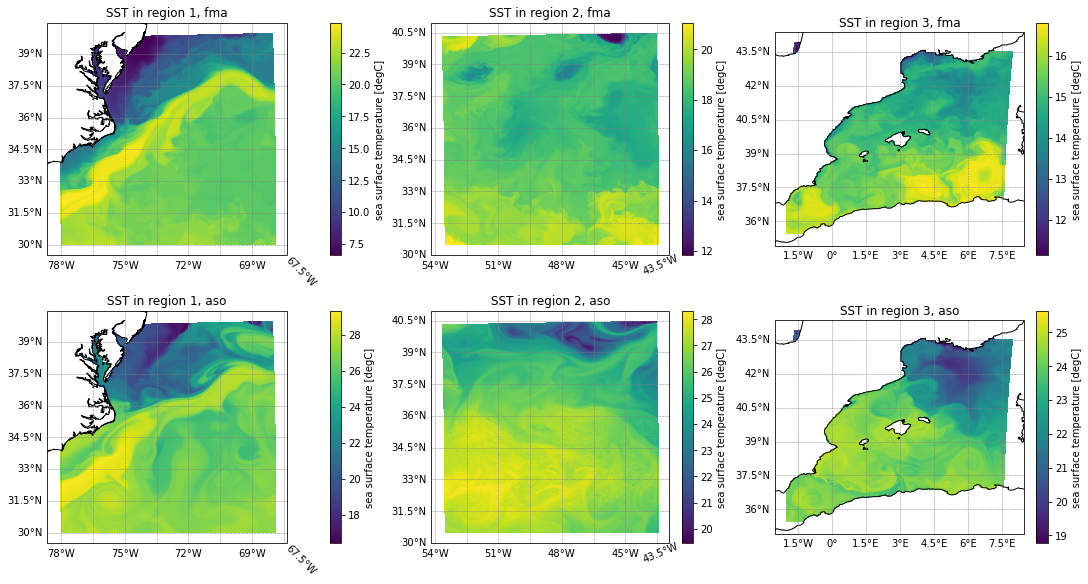

In [21]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsHR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst[coord_slice].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/SST_vs_region_season.png')

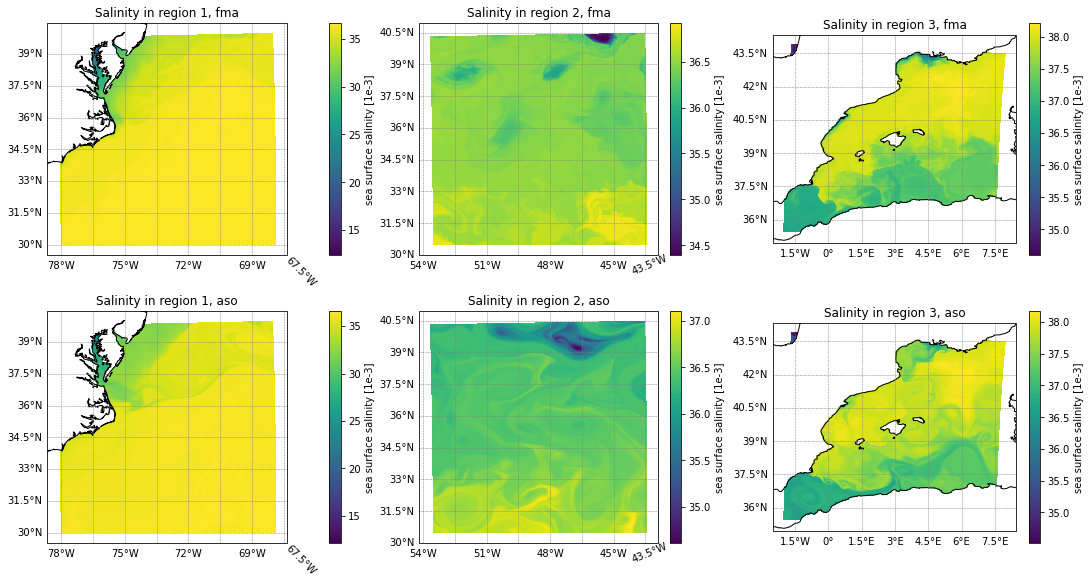

In [22]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsHR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosaline[coord_slice].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Salinity in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/Salinity_vs_region_season.png')

# Filter

Parameters (to determine) :

In [23]:
filter_scale = 30000
coarsening_window_size=12

In [24]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean','e1t':'sum', 'e2t':'sum'}).sum(skipna=False)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=False)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    new_e2t = data['e2t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    return result

In [25]:
def apply_filter_downsample(dataHR) :
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
    dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
    dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
    dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    # define the filter
    gaussian_filter = gcm_filters.Filter(
        filter_scale=filter_scale,    
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
            'kappa_w': kappa_w, 'kappa_s': kappa_s} )
    # apply filter to HR data
    data_filtered = xr.Dataset({}, coords=dataHR.coords)
    data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    # spatial coarsening
    dataLR = downsample(data_filtered, coarsening_window_size, area, wet_mask)
    return dataLR

# Downgraded data

In [26]:
dataSetsLR = []

In [27]:
for dataHR in dataSetsHR :
    %time dataLR = apply_filter_downsample(dataHR['data'])
    dataSetsLR.append({'region': dataHR['region'], 'season' : dataHR['season'], 'data': dataLR})

CPU times: user 2.31 s, sys: 213 ms, total: 2.52 s
Wall time: 15.9 s
CPU times: user 2.04 s, sys: 212 ms, total: 2.25 s
Wall time: 15.7 s
CPU times: user 2.26 s, sys: 211 ms, total: 2.47 s
Wall time: 17.1 s
CPU times: user 1.99 s, sys: 212 ms, total: 2.2 s
Wall time: 15.6 s
CPU times: user 2.4 s, sys: 182 ms, total: 2.58 s
Wall time: 14.8 s
CPU times: user 2.04 s, sys: 192 ms, total: 2.23 s
Wall time: 14.1 s


CPU times: user 91.3 ms, sys: 8.06 ms, total: 99.3 ms
Wall time: 1.65 s
CPU times: user 84.2 ms, sys: 10.4 ms, total: 94.6 ms
Wall time: 1.27 s
CPU times: user 83.4 ms, sys: 11.2 ms, total: 94.6 ms
Wall time: 1.23 s
CPU times: user 83.1 ms, sys: 12.3 ms, total: 95.4 ms
Wall time: 1.09 s
CPU times: user 89.2 ms, sys: 6.32 ms, total: 95.6 ms
Wall time: 973 ms
CPU times: user 88 ms, sys: 8.7 ms, total: 96.7 ms
Wall time: 930 ms


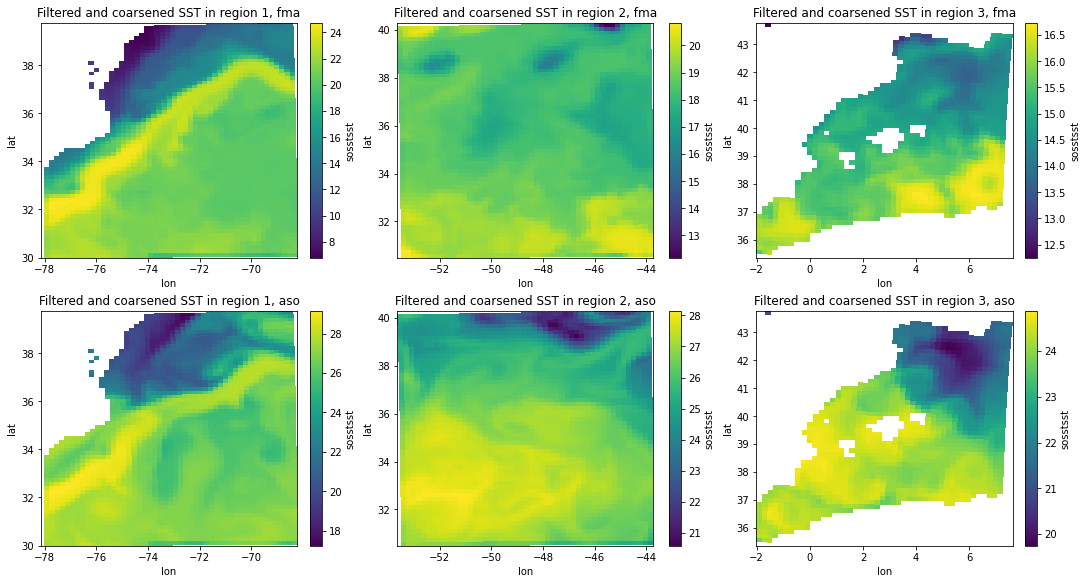

In [28]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsLR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    %time currentDataSet['data'].isel(time_counter=0).sosstsst[coord_slice].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Filtered and coarsened SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
#plt.savefig('Images/SST_filtered_downsampled_vs_region_season.png')

# Spectra

In [29]:
def uniform_grid_interpolation(data) :
    # first fill in nans
    data_filled_nans = data.interpolate_na(dim="x", method="linear")
    data_filled_nans = data_filled_nans.interpolate_na(dim="y", method="linear")
    data_filled_nans = data_filled_nans.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")
    
    # transform coordinates to uniform spacings
    delta_x_min_m = data['e1t'].min().values
    delta_y_min_m = data['e2t'].min().values
    delta_min = np.min([delta_x_min_m, delta_y_min_m])
    new_x = np.cumsum(delta_min/data['e1t'], axis=1)
    new_y = np.cumsum(delta_min/data['e2t'], axis=0)
    interpolated_field = data_filled_nans.interp(x=new_x, y=new_y).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    interpolated_field.attrs['delta_min'] = delta_min
    return interpolated_field

In [30]:
def wrapper_xrtf_isotropic_PS(data, variable, binning_factor=4) :
    interpolated_data = uniform_grid_interpolation(data[variable])
    isotropic_power_spec = xrft_module.isotropic_power_spectrum(interpolated_data, dim=['x','y'], detrend='linear',scaling="spectrum", nfactor=4, truncate=True)
    Nmin = min([len(data['x']), len(data['y'])])
    isotropic_power_spec.coords['wavenumber'] = ('freq_r', isotropic_power_spec['freq_r']/(Nmin*interpolated_data.attrs['delta_min']*0.001))
    return isotropic_power_spec.rename('Spatial spectrum')

In [31]:
# for currentDataSet in dataSetsLR :
#     spec_temp_variance = wrapper_xrtf_isotropic_PS(currentDataSet['data'], 'sosstsst', binning_factor = 2)
#     %time mean_spec_temp_variance = spec_temp_variance.mean(dim='time_counter').compute()
#     mean_spec_temp_variance.to_netcdf("Data/filter_30km_coarse_12_mean_spec_temp_variance_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

In [32]:
# for currentDataSet in dataSetsHR :
#     spec_temp_variance = wrapper_xrtf_isotropic_PS(currentDataSet['data'], 'sosstsst', binning_factor = 2)
#     %time mean_spec_temp_variance = spec_temp_variance.mean(dim='time_counter').compute()
#     mean_spec_temp_variance.to_netcdf("Data/mean_spec_temp_variance_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

# Histograms

## Salinity and SST

In [92]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t).where(dataSet.wet_mask >0), dims=['y','x'])
    normalized_weights = (area_weigths/area_weigths.sum()).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = hist/hist.sum()
    return norm_hist

In [93]:
nb_of_bins = 150

In [ ]:
for currentDataSet in dataSetsLR :
    histogram_temp_sal = compute_2D_histogram(currentDataSet['data'], 'sosaline', 'sosstsst', nb_of_bins).compute()
    histogram_temp_sal.to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

In [ ]:
for currentDataSet in dataSetsHR :
    histogram_temp_sal = compute_2D_histogram(currentDataSet['data'], 'sosaline', 'sosstsst', nb_of_bins).compute()
    histogram_temp_sal.to_netcdf("Data/Compare_histograms/hist_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of SST and salinity')
for currentDataSet in dataSetsLR :
    histogramsLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    histogramsHR = xr.open_dataset("Data/Compare_histograms/hist_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    # temperature PDFs
    hist_temp_LR = histogramsLR.histogram_sosaline_sosstsst.sum(dim='sosaline_bin')
    hist_temp_HR = histogramsHR.histogram_sosaline_sosstsst.sum(dim='sosaline_bin')
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    hist_temp_HR.plot(ax=ax[row,col], label='HR')
    hist_temp_LR.plot(ax=ax[row,col], label='LR')
    ax[row,col].set(title='SST hist in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    hist_temp_LR = histogramsLR.histogram_sosaline_sosstsst.sum(dim='sosstsst_bin')
    hist_temp_HR = histogramsHR.histogram_sosaline_sosstsst.sum(dim='sosstsst_bin')
    if (currentDataSet['season'] == 'aso') : row=3
    if (currentDataSet['season'] == 'fma') : row=2
    hist_temp_HR.plot(ax=ax[row,col], label='HR')
    hist_temp_LR.plot(ax=ax[row,col], label='LR')
    ax[row,col].set(title='Salinity hist in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
fig.suptitle('Joint distributions of temperature and salinity')
for currentDataSet in dataSetsLR :
    histogram_LR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    histogram_HR = xr.open_dataset("Data/Compare_histograms/hist_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    histogram_HR.histogram_sosaline_sosstsst.plot(x='sosaline_bin', y='sosstsst_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=10), cmap='PuBuGn')
    histogram_LR.histogram_sosaline_sosstsst.plot(x='sosaline_bin', y='sosstsst_bin', ax=ax[row,col], label='LR',norm=colors.LogNorm(vmin=1e-5, vmax=10), cmap='YlOrRd')
    ax[row,col].set(title='Joint temp-sal hist in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    #ax[row,col].legend()

## Gradients

In [ ]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [ ]:
def diffx(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffy(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [ ]:
def add_spatial_grad_to_dataset(input_dataset) :
    return xr.merge([input_dataset,
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosstsst, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosstsst, input_dataset.e2t)**2),\
                                   name='grad_temp'),
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosaline, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosaline, input_dataset.e2t)**2),\
                                   name='grad_sal')]).chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})

In [ ]:
for i in range(len(dataSetsLR)) :
    currentDataSet = dataSetsLR[i]
    currentDataSet['data'] = add_spatial_grad_to_dataset(currentDataSet['data'])
    hist_gradsLR = compute_2D_histogram(currentDataSet['data'], 'grad_sal', 'grad_temp', nb_of_bins).compute()
    hist_gradsLR.to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
    
    currentDataSet = dataSetsHR[i]
    currentDataSet['data'] = add_spatial_grad_to_dataset(currentDataSet['data'])
    hist_gradsHR = compute_2D_histogram(currentDataSet['data'], 'grad_sal', 'grad_temp', nb_of_bins, \
                                      bins=[hist_gradsLR.grad_sal_bin.values, hist_gradsLR.grad_temp_bin.values]).compute()
    hist_gradsHR.to_netcdf("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

In [ ]:
# nb_of_bins = 150
# for i in range(len(dataSetsHR)) :
#     dataSetsHR[i]['data'] = add_spatial_grad_to_dataset(dataSetsHR[i]['data'])
#     dataSetsLR[i]['data'] = add_spatial_grad_to_dataset(dataSetsLR[i]['data'])
#     binsT = np.linspace(dataSetsLR[i]['data'].grad_temp.min(), dataSetsLR[i]['data'].grad_temp.max(), nb_of_bins)
#     binsS = np.linspace(dataSetsLR[i]['data'].grad_sal.min(), dataSetsLR[i]['data'].grad_sal.max(), nb_of_bins)
#     histogram_temp_sal_LR = histogram(dataSetsLR[i]['data'].grad_sal, dataSetsLR[i]['data'].grad_temp, bins=[binsS, binsT]).compute()
#     histogram_temp_sal_LR.to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc") 
#     %time histogram_temp_sal_HR = histogram(dataSetsHR[i]['data'].grad_sal, dataSetsHR[i]['data'].grad_temp, bins=[binsS, binsT]).compute()
#     histogram_temp_sal_HR.to_netcdf("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of gradients of SST and salinity')
for currentDataSet in dataSetsLR :
    histogramsLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    histogramsHR = xr.open_dataset("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    # temperature PDFs
    hist_LR = histogramsLR.histogram_grad_sal_grad_temp.sum(dim='grad_sal_bin')
    hist_HR = histogramsHR.histogram_grad_sal_grad_temp.sum(dim='grad_sal_bin')
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    hist_HR.plot(ax=ax[row,col], label='HR')
    hist_LR.plot(ax=ax[row,col], label='LR')
    ax[row,col].set(yscale='log', title='SST grad hist in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    hist_sal_LR = histogramsLR.histogram_grad_sal_grad_temp.sum(dim='grad_temp_bin')
    hist_sal_HR = histogramsHR.histogram_grad_sal_grad_temp.sum(dim='grad_temp_bin')
    if (currentDataSet['season'] == 'aso') : row=3
    if (currentDataSet['season'] == 'fma') : row=2
    hist_sal_HR.plot(ax=ax[row,col], label='HR')
    hist_sal_LR.plot(ax=ax[row,col], label='LR')
    ax[row,col].set(yscale='log', title='Salinity grad hist in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
fig.suptitle('Joints distributions of gradients of salinity and temperature')
for currentDataSet in dataSetsLR :
    histogram_tempLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    histogram_tempHR = xr.open_dataset("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    normalized_LR = histogram_tempLR.histogram_grad_sal_grad_temp/np.max(histogram_tempLR.histogram_grad_sal_grad_temp)
    normalized_HR = histogram_tempHR.histogram_grad_sal_grad_temp/np.max(histogram_tempHR.histogram_grad_sal_grad_temp)
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    normalized_HR.plot(x='grad_sal_bin', y='grad_temp_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='PuBuGn')
    normalized_LR.plot(x='grad_sal_bin', y='grad_temp_bin', ax=ax[row,col], label='LR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='YlOrRd')
    ax[row,col].set(title='Region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    #ax[row,col].legend()

## Second derivatives of density 

In [ ]:
def add_density_derivatives(input_dataset) :
    # conservatice temperature
    CT = xr.apply_ufunc(gsw.conversions.CT_from_pt, input_dataset.sosaline, input_dataset.sosstsst, dask='parallelized')
    alpha, beta = eos_module.alpha_beta(input_dataset.sosaline, CT)
    rho_sa_sa, rho_sa_ct, rho_ct_ct = eos_module.rho_second_derivatives(input_dataset.sosaline, CT)
    return xr.merge([input_dataset,
                      xr.DataArray(alpha, name='alpha'),
                      xr.DataArray(beta, name='beta'),
                      xr.DataArray(rho_sa_sa, name='rho_sa_sa'),
                      xr.DataArray(rho_sa_ct, name='rho_sa_ct'),
                      xr.DataArray(rho_ct_ct, name='rho_ct_ct')]).chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})

In [ ]:
rho0 = 0.1 # for non-dimesionalization

In [ ]:
# nb_of_bins = 150
# for i in range(len(dataSetsHR)) :
#     dataSetsHR[i]['data'] = add_density_derivatives(dataSetsHR[i]['data'])
#     dataSetsLR[i]['data'] = add_density_derivatives(dataSetsLR[i]['data'])
#     # LR data sets 
#     non_dim_grad_T_sqr = xr.DataArray(1./rho0*dataSetsLR[i]['data'].rho_ct_ct*(diffx(dataSetsLR[i]['data'].sosstsst)**2+diffy(dataSetsLR[i]['data'].sosstsst)**2),\
#                                       name='non_dim_grad_T_sqr').chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})
#     non_dim_grad_S_sqr = xr.DataArray(1./rho0*dataSetsLR[i]['data'].rho_sa_sa*(diffx(dataSetsLR[i]['data'].sosaline)**2+diffy(dataSetsLR[i]['data'].sosaline)**2), \
#                                       name='non_dim_grad_S_sqr').chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})
#     binsT = np.linspace(non_dim_grad_T_sqr.min(), non_dim_grad_T_sqr.max(), nb_of_bins)
#     binsS = np.linspace(non_dim_grad_S_sqr.min(), non_dim_grad_S_sqr.max(), nb_of_bins)
#     histogram_temp_sal_LR = histogram(non_dim_grad_S_sqr, non_dim_grad_T_sqr, bins=[binsS, binsT]).compute()
#     histogram_temp_sal_LR.to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_nondim_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc") 
#     # HR data sets
#     non_dim_grad_T_sqr = xr.DataArray(1./rho0*dataSetsHR[i]['data'].rho_ct_ct*(diffx(dataSetsHR[i]['data'].sosstsst)**2+diffy(dataSetsHR[i]['data'].sosstsst)**2), \
#                                                                                name='non_dim_grad_T_sqr').chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})
#     non_dim_grad_S_sqr = xr.DataArray(1./rho0*dataSetsHR[i]['data'].rho_sa_sa*(diffx(dataSetsHR[i]['data'].sosaline)**2+diffy(dataSetsHR[i]['data'].sosaline)**2), name='non_dim_grad_S_sqr').chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})    
#     histogram_temp_sal_HR = histogram(non_dim_grad_S_sqr, non_dim_grad_T_sqr, bins=[binsS, binsT]).compute()
#     histogram_temp_sal_HR.to_netcdf("Data/Compare_histograms/hist_nondim_grad_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
fig.suptitle('Joints distributions of non-dimensional differences of salinity and temperature')
for currentDataSet in dataSetsLR :
    histogram_tempLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_nondim_grad_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    histogram_tempHR = xr.open_dataset("Data/Compare_histograms/hist_nondim_grad_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    normalized_LR = histogram_tempLR.histogram_non_dim_grad_S_sqr_non_dim_grad_T_sqr/np.max(histogram_tempLR.histogram_non_dim_grad_S_sqr_non_dim_grad_T_sqr)
    normalized_HR = histogram_tempHR.histogram_non_dim_grad_S_sqr_non_dim_grad_T_sqr/np.max(histogram_tempHR.histogram_non_dim_grad_S_sqr_non_dim_grad_T_sqr)
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    normalized_HR.plot(x='non_dim_grad_S_sqr_bin', y='non_dim_grad_T_sqr_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='PuBuGn')
    #normalized_LR.plot(x='non_dim_grad_S_sqr_bin', y='non_dim_grad_T_sqr_bin', ax=ax[row,col], label='LR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='YlOrRd')
    ax[row,col].set(title='Region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    #ax[row,col].legend()